In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/food.zip' .
!unzip -q food.zip
!rm food.zip

  error:  invalid compressed data to inflate food-101/images/cheesecake/1017408.jpg
file #16026:  bad zipfile offset (local header sig):  805454155
file #16027:  bad zipfile offset (local header sig):  805489509
file #16028:  bad zipfile offset (local header sig):  805529948


In [3]:
!pip install split-folders tqdm

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders

# constants
DATA_DIR = '/content/food-101/images'
SETS_DIR = '/content/sets'
BATCH_SIZE = 128

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('Found GPU: ' , device_name)

Found GPU:  /device:GPU:0


In [3]:
# remove corrupted images
num_skipped = 0
for folder_name in os.listdir(DATA_DIR):
    if folder_name == '.DS_Store':
      ds_store = os.path.join(DATA_DIR, folder_name)
      os.remove(ds_store)
      print("Removed: ", ds_store)
    else:
      folder_path = os.path.join(DATA_DIR, folder_name)
      for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
          fobj = open(fpath, "rb")
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
          fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            print("Removed: ", fpath)

print("Removed %d images" % num_skipped)

Removed 0 images


In [6]:
# create train, validation and test set
splitfolders.ratio(DATA_DIR, output=SETS_DIR, seed=123, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 100996 files [02:21, 714.56 files/s]


In [4]:
train = SETS_DIR + '/train/'
validation = SETS_DIR + '/val/'
test = SETS_DIR + '/test/'

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    color_mode='rgb', 
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    validation,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=False,
    color_mode='rgb', 
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    label_mode='int',
    seed=123,
    shuffle=False,
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

# use buffered prefetching so we can yield data 
# from disk without having I/O becoming blocking
train_set = train_set.prefetch(buffer_size=BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=BATCH_SIZE)
test_set = test_set.prefetch(buffer_size=BATCH_SIZE)

Found 70697 files belonging to 101 classes.
Found 15149 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.


In [5]:
def preprocess(images, labels):
  images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
  return images, labels
  
train_set = train_set.map(preprocess, deterministic=True)
val_set = train_set.map(preprocess, deterministic=True)
test_sset = test_set.map(preprocess, deterministic=True)


In [8]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling = 'max',   #check if avg
    input_shape=(224,224,3)
)

mobilenetv2.trainable = False

model = tf.keras.models.Sequential() 
model.add(mobilenetv2)
model.add(tf.keras.layers.Dense(512, activation='relu', name='dense_hidden_1'))
model.add(tf.keras.layers.Dense(101, activation='softmax', name='output'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_hidden_1 (Dense)       (None, 512)               655872    
_________________________________________________________________
output (Dense)               (None, 101)               51813     
Total params: 2,965,669
Trainable params: 707,685
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),  #try
              metrics=['accuracy'])

history = model.fit(
      train_set,
      epochs=30,
      verbose=1,
      validation_data=val_set,
      batch_size=BATCH_SIZE
      )

Epoch 1/2
553/553 [==============================] - 410s 715ms/step - loss: 6.4708 - accuracy: 0.0173 - val_loss: 5.5832 - val_accuracy: 0.0099
Epoch 2/2
553/553 [==============================] - 342s 615ms/step - loss: 4.3789 - accuracy: 0.0775 - val_loss: 5.5063 - val_accuracy: 0.0103


In [ ]:
# unfreeze the last block of the MobileNetV2
mobilenetv2.trainable = True

train = False
for layer in mobilenetv2.layers:
    if layer.name == 'block_16_expand':
        train = True
    if train:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),  #try
              metrics=['accuracy'])

ft_history = model.fit(
      train_dataset,
      epochs=20,
      verbose=1,
      validation_data=valid_dataset,
      batch_size=BATCH_SIZE
)

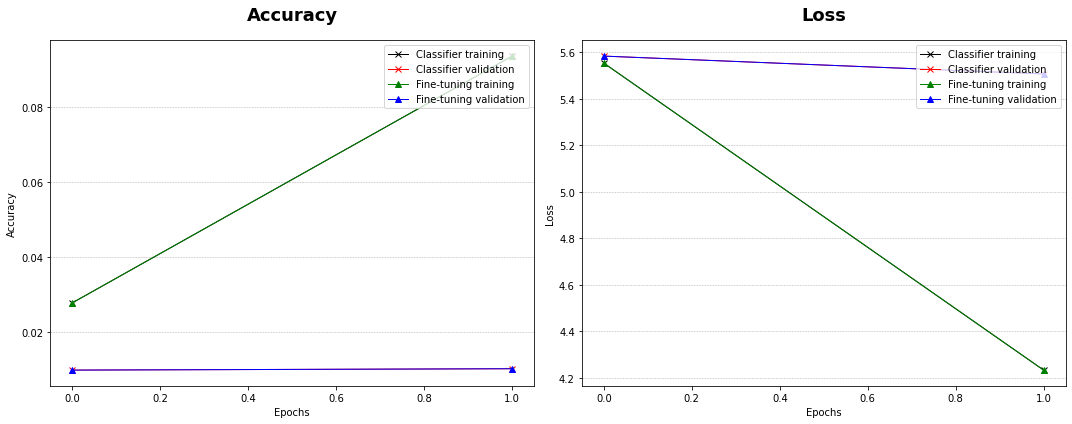

In [44]:
# data from training with freezed mobilenet
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# data from fine-tuning training
ft_acc = history.history['accuracy']
ft_val_acc = history.history['val_accuracy']
ft_loss = history.history['loss']
ft_val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))

# plot accuracy curves
acc_g.plot(epochs, acc, 'kx-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, 'rx-', label='Classifier validation', linewidth=1)
acc_g.plot(epochs, ft_acc, 'g^-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs, ft_val_acc, 'b^-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, 'kx-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, 'rx-', label='Classifier validation', linewidth=1)
loss_g.plot(epochs, ft_loss, 'g^-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs, ft_val_loss, 'b^-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18, 'fontweight':'bold'}, pad=20)
acc_g.legend(loc='upper right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18, 'fontweight':'bold'}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

# save graph
fig.savefig('train_plots.png')

In [40]:
test_loss, test_accuracy = model.evaluate(test_set)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

119/119 [==============================] - 35s 296ms/step - loss: 6.1520 - accuracy: 0.0094
Test loss:  6.151988506317139
Test accuracy:  0.009438944049179554


In [10]:
model.save('/content/model.h5')

In [ ]:
# TODO: feature extraction with the fine-tuned model